In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
!unzip '/content/drive/MyDrive/sign_mnist_train.csv.zip' -d '/content/slmnist'
!unzip '/content/drive/MyDrive/sign_mnist_test.csv.zip' -d '/content/slmnist'

Archive:  /content/drive/MyDrive/sign_mnist_train.csv.zip
replace /content/slmnist/sign_mnist_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/slmnist/sign_mnist_train.csv  
Archive:  /content/drive/MyDrive/sign_mnist_test.csv.zip
replace /content/slmnist/sign_mnist_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/slmnist/sign_mnist_test.csv  


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn import preprocessing as sklpp
from sklearn import decomposition as skldecomp
from sklearn import svm
import seaborn as sn #This is to make confusion matrices look nice
import time

letters = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

#Exploration of Dataset

In [ ]:
df = pd.read_csv('/content/slmnist/sign_mnist_train.csv')
df['label'] = df['label'].replace(to_replace = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                    value = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,12,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,22,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,17,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,16,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [ ]:
print(f'Number of features: {df.shape[0]}')

Number of features: 27455


In this dataset, each feature is a pixel of the image. These have values from 0 to 255. There is one label which corresponds to the letter of the sign. The letters are represented by their position in the alphabet. The letters 'J' and 'Z' are missing due to the sign for these involving motion that cannot be represented in an image. Accordingly, every label after 'J' has their number shifted up by 1 for ease of working with the dataset. 

<BarContainer object of 784 artists>

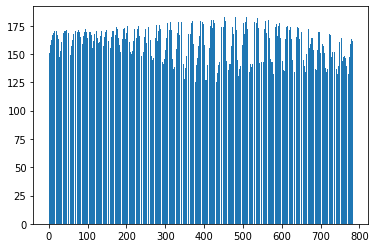

In [ ]:
featureMeans = df.drop(columns = 'label').mean()
plt.bar(list(range(df.shape[1]-1)),featureMeans)

In [ ]:
def grayImage(index, data,size = 28):
  img = np.zeros([size,size])
  for i in range(size):
    img[i,:] = data.iloc[index, (i*size):(i*size+size)]
  plt.gray()
  plt.matshow(img)

<Figure size 432x288 with 0 Axes>

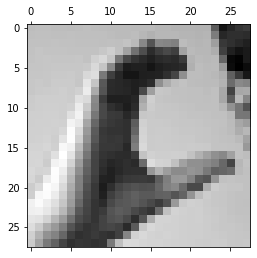

In [ ]:
grayImage(2, df.drop(columns = 'label'))
myData = df.drop(columns = 'label').to_numpy()

Each data sample is a 28x28 grayscale image. They consist of a hand centered in the screen making a sign language letter.

In [ ]:
def findEnergy(sig, max_val, start_val = 0):
  useSig = sig[start_val:max_val]
  return sum(np.square(useSig))

In [ ]:
mean_datascalar = sklpp.StandardScaler(with_mean=True, with_std=True)
myData_centered = mean_datascalar.fit_transform(myData)
real_data = skldecomp.PCA(n_components = .95, svd_solver = 'full')
data_features = real_data.fit_transform(myData_centered)
print(f'Number of principle components needed: {real_data.n_components_}')

Number of principle components needed: 115


95% enery captured is used in order to reduce the number of features as much as possible while maintaining most of the information in the dataset.This is done because even a small 28x28 image will have 784 features associated. In this instance it is important to reduce dimensionality so the machine learning algoritm can train faster. In addition, the data has standard deviation of 1. This is so no one pixel will influence the data more than another.

<ipython-input-36-e22d206ff204>:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem((real_data.singular_values_)**2)


<StemContainer object of 3 artists>

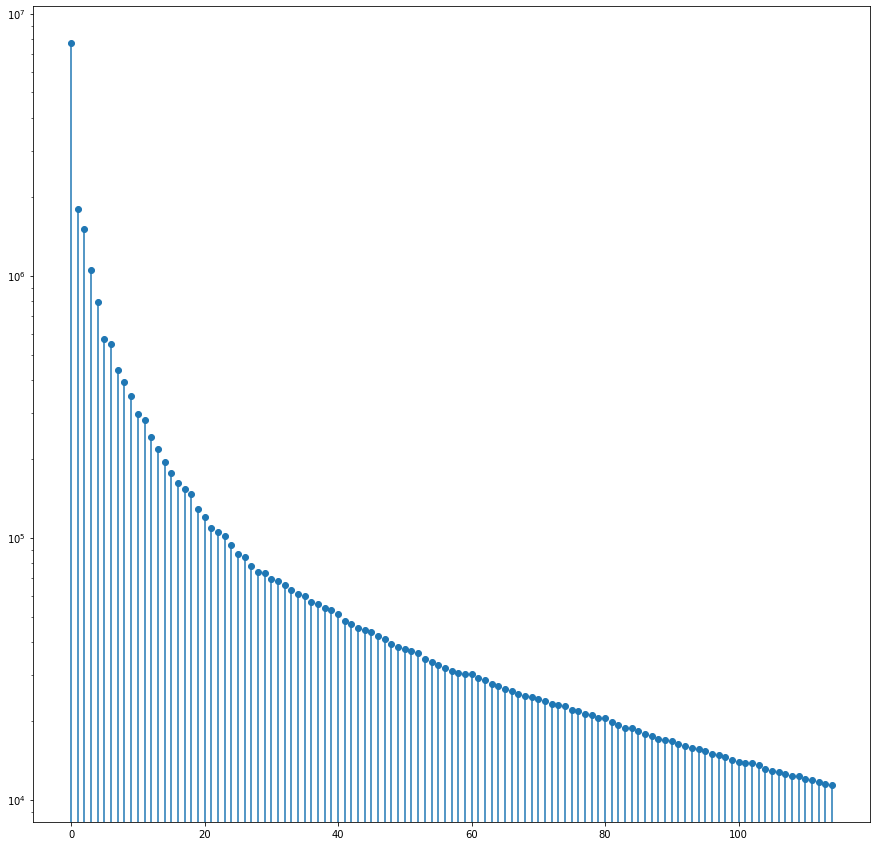

In [ ]:
fig = plt.figure(figsize = [15,15])
plt.yscale('log')
plt.stem((real_data.singular_values_)**2)

<Figure size 432x288 with 0 Axes>

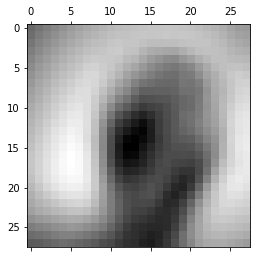

In [ ]:
img = np.zeros([28,28])
inverse_components = mean_datascalar.inverse_transform([real_data.components_[1,:]])
for i in range(28):
  img[i,:] = inverse_components[0, (i*28):(i*28+28)]
plt.gray()
plt.matshow(img)

Above is the principal component with the largest sigma value. This means it is the most important principle component. This makes sense because it is essentially a fist in the center of the image. This makes sense since most sign language letters start this way.

<Figure size 432x288 with 0 Axes>

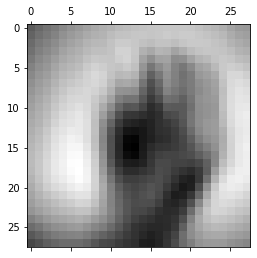

In [ ]:
img = np.zeros([28,28])

inverse_components = mean_datascalar.inverse_transform([real_data.components_[31,:]])
for i in range(28):
  img[i,:] = inverse_components[0, (i*28):(i*28+28)]
plt.gray()
plt.matshow(img)

These are some examples of the most important structures in a hand sign. It makes sense that a fist is the most important structure for making hand signs. Many originate from that position.

In [ ]:
df_f = pd.DataFrame(data_features)
df_f['label'] = df['label']

In [ ]:
print(df_f.mean())

0       -2.380985e-17
1       -6.625348e-17
2        3.726758e-17
3       -8.281686e-18
4       -4.347885e-17
             ...     
111      1.501055e-17
112      1.164612e-17
113      4.140843e-18
114     -9.316896e-18
label    1.167948e+01
Length: 116, dtype: float64


#QDA

In [ ]:
QDATrainTime = time.time()
means = df_f.groupby('label').mean() #Means is a pandas DataFrame
cov = np.zeros([24, real_data.n_components_, real_data.n_components_])
groups = df_f.groupby('label')
for i in range(24):
    classDf = groups.get_group(i)
    classDf = classDf.drop(axis = 1, labels = 'label')
    classMean = classDf.mean().to_numpy()
    sum = np.zeros([real_data.n_components_, real_data.n_components_])
    for j in range(classDf.shape[0]):
      dataSample = classDf.iloc[j].to_numpy()
      sum = sum + np.outer((dataSample - classMean), (dataSample - classMean))
    cov[i] = sum/classDf.shape[0]
priors = df_f.value_counts(['label'])/df_f.shape[0]
QDATrainTime = time.time()-QDATrainTime

In [ ]:
def QDA(inputImage, mean_datascalar, real_data, mean, cov, priors):

  inputImage = np.reshape(inputImage[:],[1,inputImage.size])

  inputImage_centered = mean_datascalar.transform(inputImage)
  data_features = real_data.transform(inputImage_centered)
  delta = np.ones(23) * np.inf
  for i in range(23):
      E = cov[i]
      m = mean.loc[i].to_numpy()
      p = priors.loc[i].to_numpy()
      d = -0.5*np.matmul((data_features),np.matmul( np.linalg.inv(E), data_features.T))
      d = d + np.matmul((data_features),np.matmul( np.linalg.inv(E), m))
      d = d - 0.5 * np.matmul((m), np.matmul(np.linalg.inv(E), m))
      d = d - 0.5 * np.log(np.linalg.det(E)) + np.log(p)
      delta[i] = d
      
  return np.argmax(delta)


Predicted value: U
Actual Value: U


<Figure size 432x288 with 0 Axes>

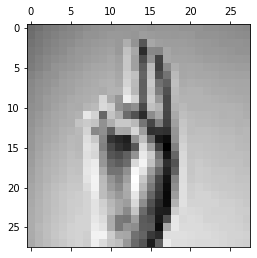

In [ ]:
testNumber = 150
inputImage = df.iloc[testNumber].to_numpy()
grayImage(testNumber, df.drop(columns = 'label'))
inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
print("Predicted value: " + letters[QDA(inputImage, mean_datascalar, real_data, means, cov, priors)])
print("Actual Value: " + letters[df.loc[testNumber,'label']])

In [ ]:
QDATestTime = time.time()
np.set_printoptions(suppress=True)
df_test = pd.read_csv('/content/slmnist/sign_mnist_test.csv')
df_test['label'] = df_test['label'].replace(to_replace = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                    value = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
confMatrixQDA = np.zeros([24,24])

for i in range(df_test.shape[0]):

  inputImage = df_test.iloc[i].to_numpy()
  inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
  response = QDA(inputImage, mean_datascalar, real_data, means, cov, priors)
  confMatrixQDA[df_test.loc[i,'label'], response] += 1
QDATestTime = time.time() - QDATestTime
print(f'Testing completed in {QDATestTime // 60:.0f}m {QDATestTime % 60:.0f}s')

Testing completed in 8m 58s


Q
H


<Figure size 432x288 with 0 Axes>

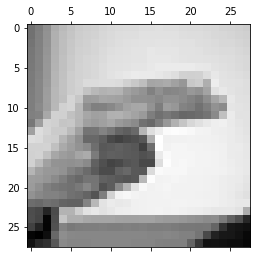

In [ ]:
testVal = 28
inputImage = df_test.iloc[testVal].to_numpy()
grayImage(testVal, df_test.drop(columns = 'label'))
inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
print(letters[QDA(inputImage, mean_datascalar, real_data, means, cov, priors)])
print(letters[df_test.loc[testVal,'label']])

#LDA

In [ ]:
LDATrainTime = time.time()
cov = np.zeros([real_data.n_components_, real_data.n_components_])
groups = df_f.groupby('label')
for i in range(24):
    classDf = groups.get_group(i)
    classDf = classDf.drop(axis = 1, labels = 'label')
    classMean = classDf.mean().to_numpy()
    for j in range(classDf.shape[0]):
      dataSample = classDf.iloc[j].to_numpy()
      cov = cov + np.outer((dataSample - classMean), (dataSample - classMean))
cov = cov/df_f.shape[0]
priors = df_f.value_counts(['label'])/df_f.shape[0]
LDATrainTime = time.time() - LDATrainTime

In [ ]:
def LDA(inputImage, mean_datascalar, real_data, mean, cov, priors):

  inputImage = np.reshape(inputImage[:],[1,inputImage.size])

  inputImage_centered = mean_datascalar.transform(inputImage)
  data_features = real_data.transform(inputImage_centered)
  delta = np.zeros(24)
  delta[9] = float('-inf')
  for i in range(24):
      E = cov
      m = mean.loc[i].to_numpy()
      p = priors.loc[i].to_numpy()
      d = np.matmul((data_features),np.matmul( np.linalg.inv(E), m.T))
      d = d - 0.5 * np.matmul((m), np.matmul(np.linalg.inv(E), m))
      d = d + np.log(p)
      delta[i] = d
      
  return np.argmax(delta)

In [ ]:
df_test = pd.read_csv('/content/slmnist/sign_mnist_test.csv')
df_test['label'] = df_test['label'].replace(to_replace = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                    value = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

LDATestTime = time.time()

confMatrixLDA = np.zeros([24,24])

for i in range(df_test.shape[0]):

  inputImage = df_test.iloc[i].to_numpy()
  inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
  response = LDA(inputImage, mean_datascalar, real_data, means, cov, priors)
  confMatrixLDA[df_test.loc[i,'label'], response] += 1

LDATestTime = time.time() - LDATestTime
print(f'Testing completed in {LDATestTime // 60:.0f}m {LDATestTime % 60:.0f}s')

Testing completed in 5m 52s


I
I


<Figure size 432x288 with 0 Axes>

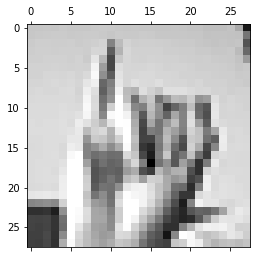

In [ ]:
testVal = 10
inputImage = df_test.iloc[testVal].to_numpy()
grayImage(testVal, df_test.drop(columns = 'label'))
inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
print(letters[LDA(inputImage, mean_datascalar, real_data, means, cov, priors)])
print(letters[df_test.loc[testVal,'label']])

#SVM

To implement a support vector machine,sciKit-Learn is used. In particular, the SVM class is used. This SVM implementation uses Sequential Minimal Optimization to solve for the equation of the hyperplane. For this dataset, the linear kernel is used. This essentially means it is a linear support vector classifier. The tolerance for the optimizer to stop is left unchanged as testing proved 1e-3 is enough. The other parameters are not important for the usage in this python notebook. For example, decision_function_shape, which specifies if the SVC should use one-vs-one or one-vs-all, is not important since one-vs-one is implemented in this python notebook. The only other important parameter is C which is elaborated on further in the notebook. This information is from the Scikit learn website and microsoft paper. 

In [ ]:
def calculateLoss(svm, testData): #Should actually be calculateError
  error = 0
  data_features = testData.drop(axis = 1, labels = 'label').to_numpy() 
  for i in range(testData.shape[0]):
    pred = svm.predict(data_features[i].reshape(1, -1) )
    actual = testData['label'].iloc[i]
    if(pred != actual):
      error += 1
  return (error/testData.shape[0])

In [ ]:
def crossValidationSVC(df):
  train = df.copy()
  train.reset_index(drop=True, inplace=True)
  trainLength = train.shape[0]
  folds = [pd.DataFrame() for i in range(5)]
  currentFold = 0
  for i in range(trainLength):
    randInt = np.random.randint(0,train.shape[0])
    folds[currentFold] = (folds[currentFold]).append(train.iloc[randInt,:])
    train = train.drop(randInt)
    train.reset_index(drop=True, inplace=True)
    currentFold = (currentFold + 1) % 5
  for fold in folds:
    fold.reset_index(drop= True, inplace = True)


  regularizationVals = [1, 0.01, 0.1, 10, 100]
  errors = np.zeros(len(regularizationVals))

  for j in range(5):
    trainData = pd.DataFrame()
    testData = folds[j]
    for k in range(5):
      if(k != j):
        trainData = trainData.append(folds[k])
    trainData.reset_index(drop = True, inplace= True)
    for i in range(len(regularizationVals)):
      trainFeatures = trainData.drop(axis = 1, labels = 'label').to_numpy()
      trainLabels = trainData['label'].to_numpy()
      testSVM = svm.SVC(kernel = 'linear', C = regularizationVals[i])
      testSVM.fit(trainFeatures, trainLabels)
      errors[i] += calculateLoss(testSVM, testData)
  return svm.SVC(kernel = 'linear', C = regularizationVals[np.argmin(errors)]),  regularizationVals[np.argmin(errors)], np.min(errors)

A logarithmic scale is used to get the best range of C's tested while not testing too many values that computation time increases to absurd amounts.

In [ ]:
svmCrossValTime = time.time()
groups = df_f.groupby('label')

classifiers = [[svm.SVC(kernel = 'linear') for i in range(24)] for j in range(24)]
cs= [[0 for i in range(24)] for j in range(24)]
groupA = groups.get_group(1)

for i in range(24):
  for j in range(i):
    if(i != j):
      groupA = groups.get_group(i)
      groupB = groups.get_group(j)
      crossDf = groupA.append(groupB)
      classifiers[i][j], cs[i][j], error = crossValidationSVC(crossDf)
      print(f'{letters[i]} vs {letters[j]}: Done, C = {cs[i][j]}; Error = {error}')
svmCrossValTime = time.time()-svmCrossValTime
print(f'Cross validating completed in {svmCrossValTime // 60:.0f}m {svmCrossValTime % 60:.0f}s')

B vs A: Done, C = 1; Error = 0.0
C vs A: Done, C = 1; Error = 0.0
C vs B: Done, C = 1; Error = 0.0
D vs A: Done, C = 1; Error = 0.0
D vs B: Done, C = 1; Error = 0.0
D vs C: Done, C = 1; Error = 0.0
E vs A: Done, C = 1; Error = 0.0
E vs B: Done, C = 1; Error = 0.0
E vs C: Done, C = 1; Error = 0.0
E vs D: Done, C = 1; Error = 0.0
F vs A: Done, C = 1; Error = 0.0
F vs B: Done, C = 1; Error = 0.0
F vs C: Done, C = 1; Error = 0.0
F vs D: Done, C = 1; Error = 0.0
F vs E: Done, C = 1; Error = 0.0
G vs A: Done, C = 1; Error = 0.0
G vs B: Done, C = 1; Error = 0.0
G vs C: Done, C = 1; Error = 0.0
G vs D: Done, C = 1; Error = 0.0
G vs E: Done, C = 1; Error = 0.0
G vs F: Done, C = 1; Error = 0.0
H vs A: Done, C = 1; Error = 0.0
H vs B: Done, C = 1; Error = 0.0
H vs C: Done, C = 1; Error = 0.0
H vs D: Done, C = 1; Error = 0.0
H vs E: Done, C = 1; Error = 0.0
H vs F: Done, C = 1; Error = 0.0
H vs G: Done, C = 1; Error = 0.0
I vs A: Done, C = 1; Error = 0.0
I vs B: Done, C = 1; Error = 0.0
I vs C: Do

Upon firther inspection, the training error is zero. This could imply overfitting of the training data, however the classifier performs quite well on testing data. In the scikit learn package, C represents the penalty. This is that serves the same purpose as the margin slack that was learned in class

In [ ]:
svmTrainTime = time.time()
for i in range(24):
  for j in range(i):
    if(i != j):
      classifiers[i][j] = svm.SVC(kernel = 'linear', C = cs[i][j])
      groupA = groups.get_group(i)
      groupB = groups.get_group(j)
      groupAdata = groupA.drop(axis = 1, labels = 'label').to_numpy()
      groupBdata = groupB.drop(axis = 1, labels = 'label').to_numpy()
      groupAlabel = groupA['label'].to_numpy()
      groupBlabel = groupB['label'].to_numpy()
      trainData = np.vstack([groupAdata, groupBdata])
      labelData = np.hstack([groupAlabel, groupBlabel])
      classifiers[i][j].fit(trainData, labelData)
svmTrainTime = time.time() - svmTrainTime

In [ ]:
#Datasample is numpy
def runSVM(inputImage):
  inputImage = np.reshape(inputImage[:],[1,inputImage.size])
  inputImage_centered = mean_datascalar.transform(inputImage)
  data_features = real_data.transform(inputImage_centered)
  votes = np.zeros(24)
  for i in range(24):
    for j in range(i):
      if(i != j):
        soln = classifiers[i][j].predict(data_features)
        votes[soln] = votes[soln] + 1
  return np.argmax(votes)

In [ ]:
df_test = pd.read_csv('/content/slmnist/sign_mnist_test.csv')
df_test['label'] = df_test['label'].replace(to_replace = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                    value = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

Predicted:F
Actual: F


<Figure size 432x288 with 0 Axes>

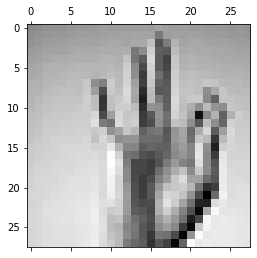

In [ ]:
testNumber = 1
inputImage = df_test.iloc[testNumber].to_numpy()
grayImage(testNumber, df_test.drop(columns = 'label'))
inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
print("Predicted:" + letters[runSVM(inputImage)])
print("Actual: " + letters[df_test.loc[testNumber,'label']])

In [ ]:
import time
df_test = pd.read_csv('/content/slmnist/sign_mnist_test.csv')
df_test['label'] = df_test['label'].replace(to_replace = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
                    value = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
svmTestTime = time.time()
confMatrixSVM = np.zeros([24,24])

for i in range(df_test.shape[0]):
  inputImage = df_test.iloc[i].to_numpy()
  inputImage = np.reshape(inputImage[1:inputImage.size],[1,inputImage.size-1])
  response = runSVM(inputImage)
  confMatrixSVM[df_test.loc[i,'label'], response] += 1
svmTestTime = time.time() - svmTestTime

print(f'Testing completed in {svmTestTime // 60:.0f}m {svmTestTime % 60:.0f}s')

Testing completed in 6m 31s


#Evaluation



In [ ]:
def findTotalAccuracy(confMatrix):
  total = 0
  for i in range(confMatrix.shape[0]):
    total += confMatrix[i,i]
  return total/np.sum(confMatrix)

In [ ]:
def measure(m):
  overallAccuracy = 0
  avgAccuracy = 0
  avgRecall = 0
  avgPrecision = 0
  avgfScore = 0
  classRecall = []
  classPrec = []
  classF = []
  classAcc = []
  for i in range(len(m[0])):
    TP = m[i,i]
    FN = np.sum(m[i,:]) - TP
    FP = np.sum(m[:,i]) - TP
    total = np.sum(m)
    TN =  total - FN - FP - TP
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    fScore = (2*precision*recall)/(precision + recall)
    classRecall.append(recall)
    classPrec.append(precision)
    classF.append(fScore)
    classAcc.append(((TP+TN)/total))
    avgAccuracy = avgAccuracy + ((TP+TN)/total)
    avgRecall = avgRecall + recall
    avgPrecision = avgPrecision + precision
    avgfScore = avgfScore + fScore
  classRecall.append(avgRecall/len(m[0]))
  classPrec.append(avgPrecision/len(m[0]))
  classF.append(avgfScore/len(m[0]))
  classAcc.append(avgAccuracy/len(m[0]))
  return classRecall, classPrec, classF, classAcc, (avgAccuracy/len(m[0]))

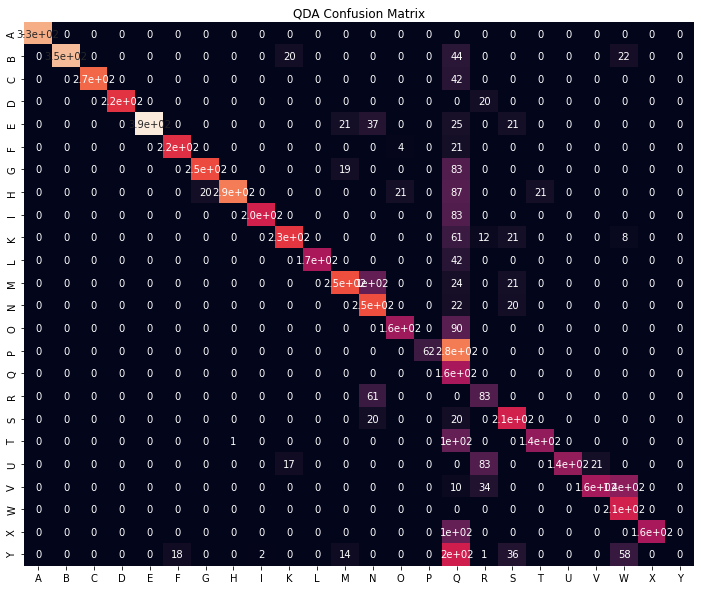

In [ ]:
df_cmQDA = pd.DataFrame(confMatrixQDA, index = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"], columns = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"])
plt.figure(figsize = (12,10))
plt.title("QDA Confusion Matrix")
sn.heatmap(df_cmQDA,annot=True, cbar = False)

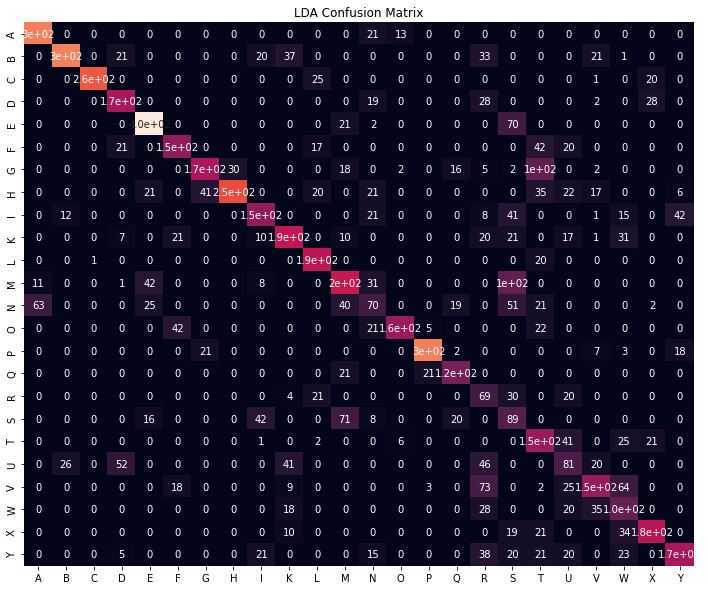

In [ ]:
df_cmLDA = pd.DataFrame(confMatrixLDA, index = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"], columns = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"])
plt.figure(figsize = (12,10))
plt.title("LDA Confusion Matrix")
sn.heatmap(df_cmLDA,annot=True, cbar = False)

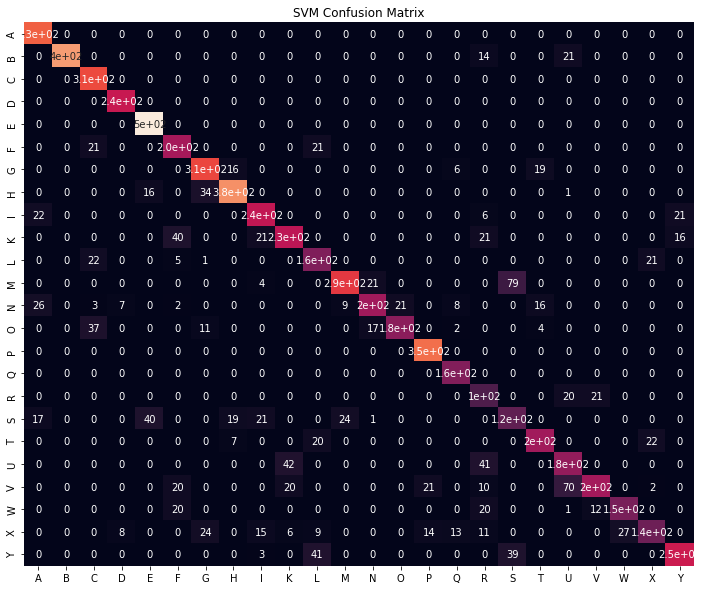

In [ ]:
df_cmSVM = pd.DataFrame(confMatrixSVM, index = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"], columns = [i for i in "ABCDEFGHIKLMNOPQRSTUVWXY"])
plt.figure(figsize = (12,10))
plt.title("SVM Confusion Matrix")
sn.heatmap(df_cmSVM,annot=True, cbar = False)

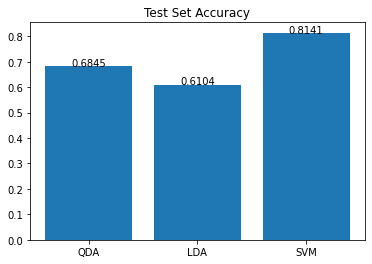

In [ ]:
QDAAcc = findTotalAccuracy(confMatrixQDA)
LDAAcc = findTotalAccuracy(confMatrixLDA)
SVMAcc = findTotalAccuracy(confMatrixSVM)

fig = plt.figure()
plt.bar(x = ["QDA", "LDA", "SVM"], height = [QDAAcc, LDAAcc, SVMAcc])
plt.text("QDA", QDAAcc, "{:.4f}".format(QDAAcc), ha = 'center')
plt.text("LDA", LDAAcc, "{:.4f}".format(LDAAcc), ha = 'center')
plt.text("SVM", SVMAcc, "{:.4f}".format(SVMAcc), ha = 'center')
plt.title("Test Set Accuracy")
plt.show()

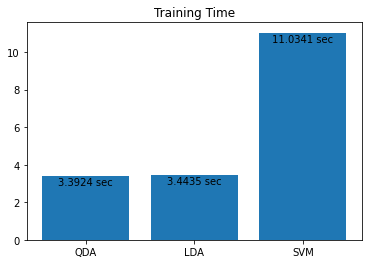

In [ ]:
fig = plt.figure()
plt.bar(x = ["QDA", "LDA", "SVM"], height = [QDATrainTime, LDATrainTime, svmTrainTime])
plt.text("QDA", QDATrainTime - .5, "{:.4f} sec".format(QDATrainTime), ha = 'center')
plt.text("LDA", LDATrainTime - .5, "{:.4f} sec".format(LDATrainTime), ha = 'center')
plt.text("SVM", svmTrainTime - .5, "{:.4f} sec".format(svmTrainTime), ha = 'center')
plt.title("Training Time")
plt.show()

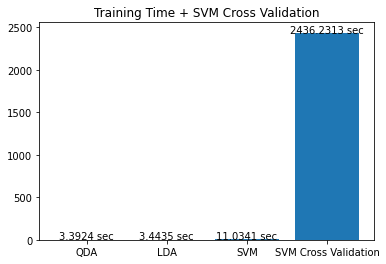

In [ ]:
fig = plt.figure()
plt.bar(x = ["QDA", "LDA", "SVM", "SVM Cross Validation"], height = [QDATrainTime, LDATrainTime, svmTrainTime, svmCrossValTime])
plt.text("QDA", QDATrainTime, "{:.4f} sec".format(QDATrainTime), ha = 'center')
plt.text("LDA", LDATrainTime, "{:.4f} sec".format(LDATrainTime), ha = 'center')
plt.text("SVM", svmTrainTime, "{:.4f} sec".format(svmTrainTime), ha = 'center')
plt.text("SVM Cross Validation", svmCrossValTime, "{:.4f} sec".format(svmCrossValTime), ha = 'center')
plt.title("Training Time + SVM Cross Validation")
plt.show()

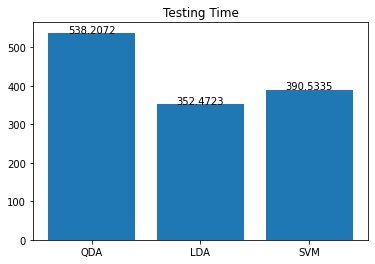

In [ ]:
fig = plt.figure()
plt.bar(x = ["QDA", "LDA", "SVM"], height = [QDATestTime, LDATestTime, svmTestTime])
plt.text("QDA", QDATestTime, "{:.4f}".format(QDATestTime), ha = 'center')
plt.text("LDA", LDATestTime, "{:.4f}".format(LDATestTime), ha = 'center')
plt.text("SVM", svmTestTime, "{:.4f}".format(svmTestTime), ha = 'center')
plt.title("Testing Time")
plt.show()

<ipython-input-161-c21de2a7eafb>:18: RuntimeWarning: invalid value encountered in double_scalars
  precision = TP/(TP+FP)


<BarContainer object of 25 artists>

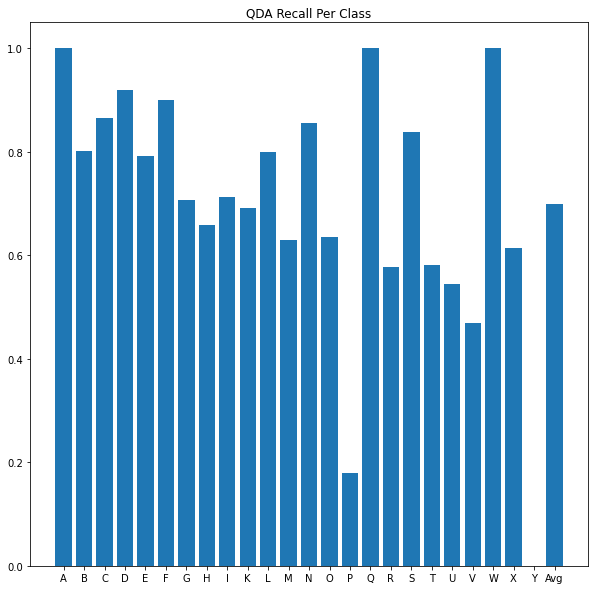

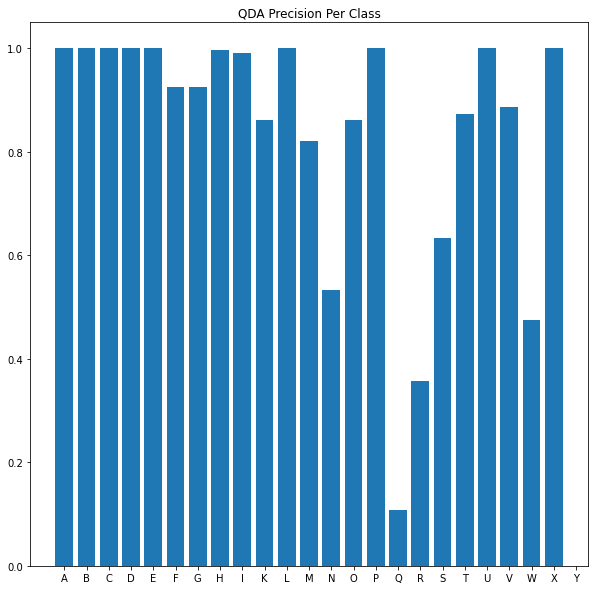

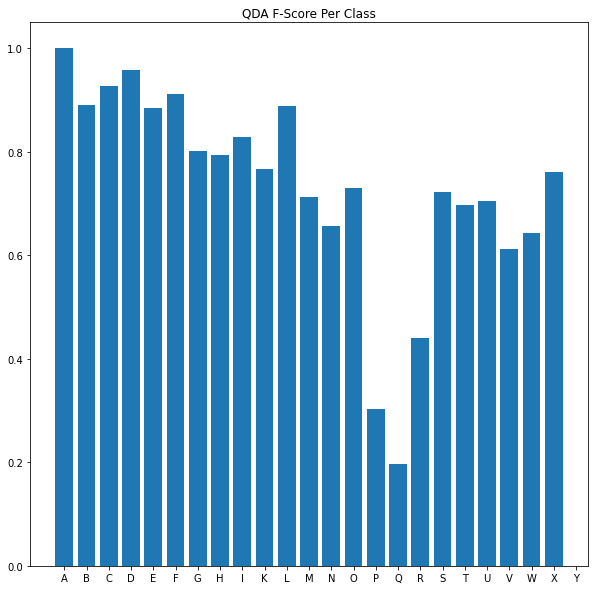

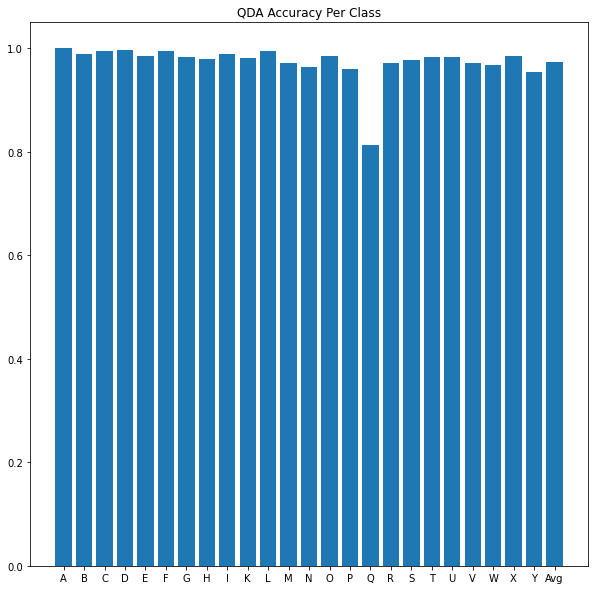

In [ ]:
QDARecall, QDAPrec, QDAFScore, QDAAcc, QDAAvg = measure(confMatrixQDA)
plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("QDA Recall Per Class")
plt.bar(x = xaxis, height = QDARecall)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("QDA Precision Per Class")
plt.bar(x = xaxis, height = QDAPrec)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("QDA F-Score Per Class")
plt.bar(x = xaxis, height = QDAFScore)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("QDA Accuracy Per Class")
plt.bar(x = xaxis, height = QDAAcc)

In the above graphs, one can see the per class recall, precision, F-Score, and accuracy. This is essentially treating each class with a one-vs-all standpoint to calculate recall, precision, and F-Score. Some of the more interesting points are for Q and Y. The Letter Y is zero for all three. This is because the letter Y has 0% accuracy. Meanwhile, the letter Q has very high recall but very low precision. This means that many letters are classified as Q when they should not be.

<BarContainer object of 25 artists>

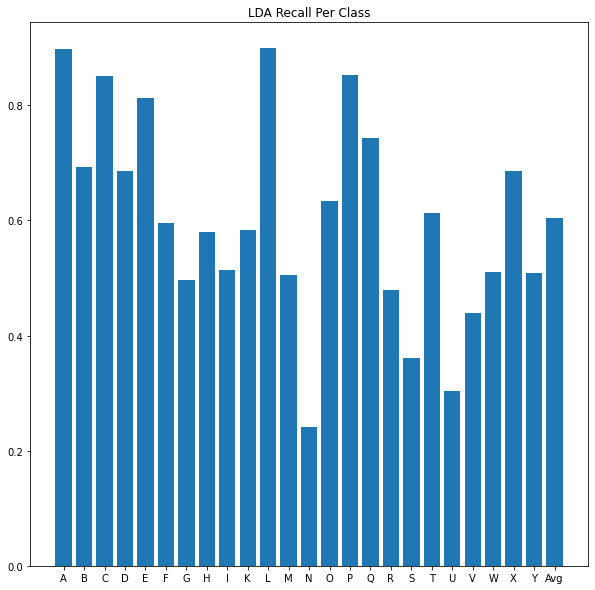

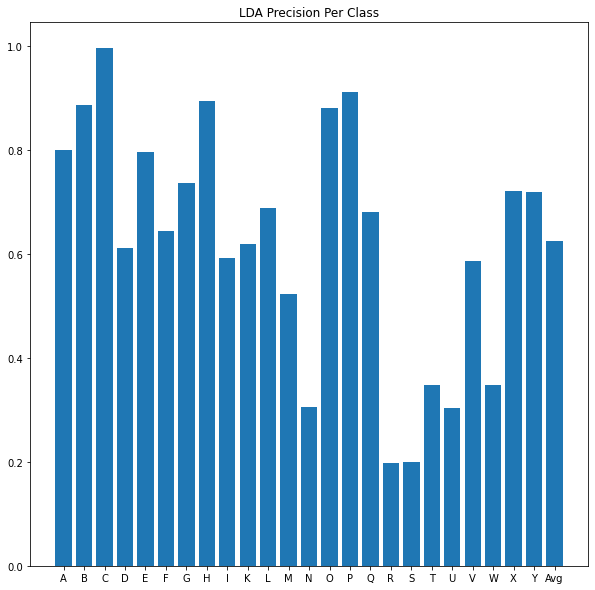

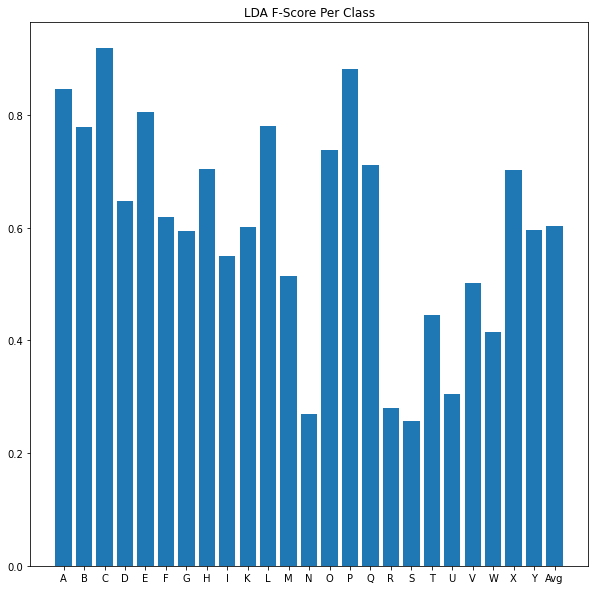

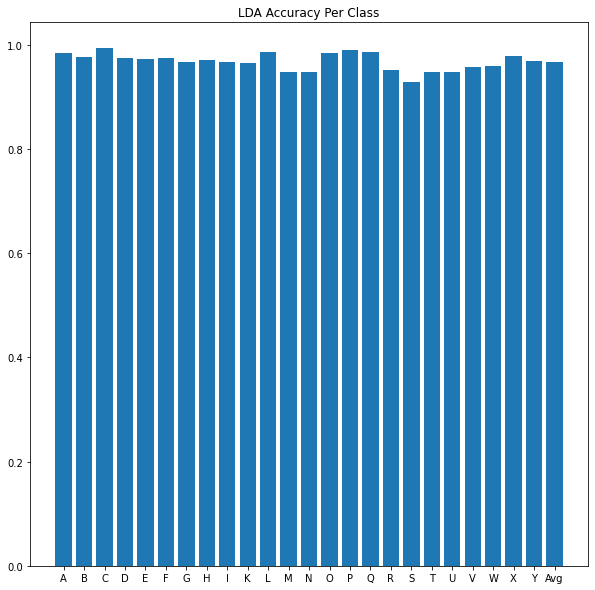

In [ ]:
LDARecall, LDAPrec, LDAFScore, LDAAcc, LDAAvg = measure(confMatrixLDA)
plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("LDA Recall Per Class")
plt.bar(x = xaxis, height = LDARecall)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("LDA Precision Per Class")
plt.bar(x = xaxis, height = LDAPrec)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("LDA F-Score Per Class")
plt.bar(x = xaxis, height = LDAFScore)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("LDA Accuracy Per Class")
plt.bar(x = xaxis, height = LDAAcc)

<BarContainer object of 25 artists>

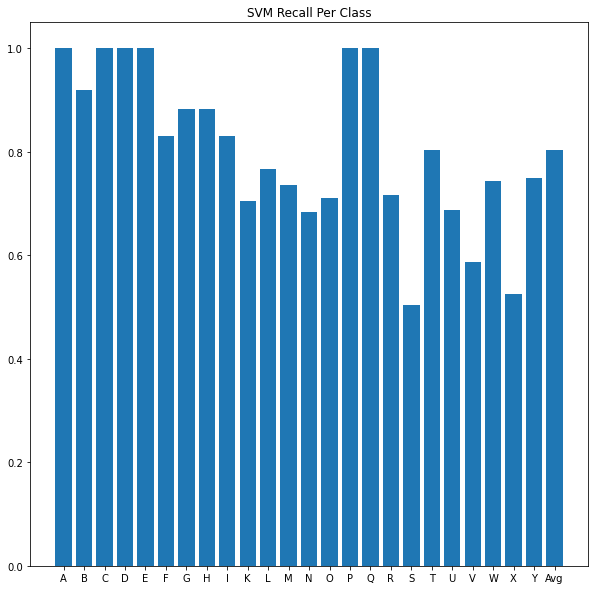

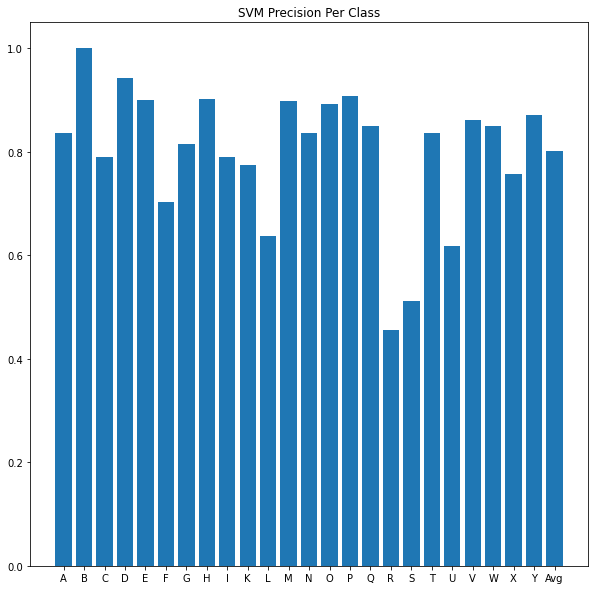

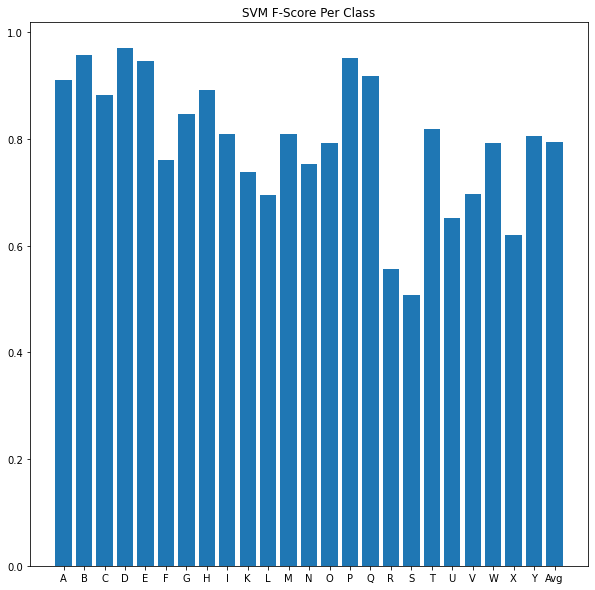

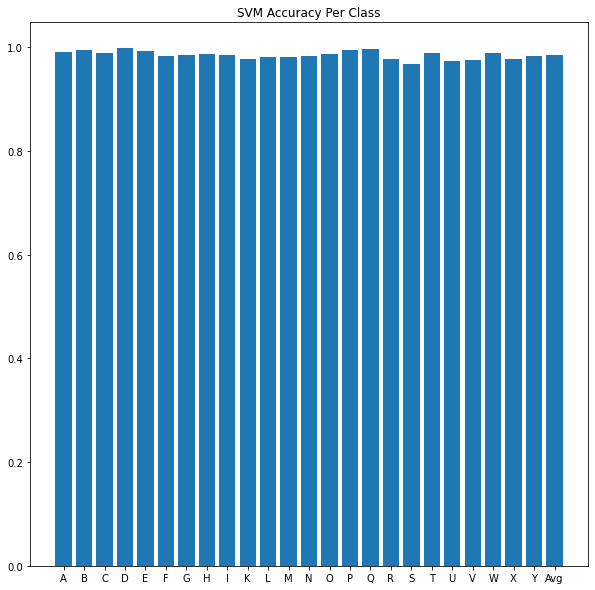

In [ ]:
SVMRecall, SVMPrec, SVMFScore, SVMAcc, SVMAvg = measure(confMatrixSVM)
plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("SVM Recall Per Class")
plt.bar(x = xaxis, height = SVMRecall)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("SVM Precision Per Class")
plt.bar(x = xaxis, height = SVMPrec)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("SVM F-Score Per Class")
plt.bar(x = xaxis, height = SVMFScore)

plt.figure(figsize = [10,10])
xaxis = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'K', 'L', 'M','N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Avg']
plt.title("SVM Accuracy Per Class")
plt.bar(x = xaxis, height = SVMAcc)

In the above graphs, one can see per class recall, precision, F-Score, and accuracy. It should be of note that overall, these values are more level than the LDA and QDA. This indicates that on a class by class basis, SVM is generally better. 

#Recommendation

The recommended algorithm for this task is SVM. This is mainly due to its high accuracy when compared to QDA and LDA. In addition, the evaluation time is around the same as the other two methods. The only issue is the training time for cross validation, however this only occurs once and the need for accuracy greatly outweighs the need for fast training time. Based on the desire for higher accuracy, SVM is the recommended algorithm

#Ethical Issues

There are many ethical issues with this dataset. Firstly, the machine learning algorithm needs to be accuracte. If the classifier is not accurate, this could cause issues for people trying to use the system. For example, if this system was implemented as a way for people to input their name website, it is important for signs to be calculated accuratly.

#Bibliography
For SVM:

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/svm.html

https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html

https://www.microsoft.com/en-us/research/publication/fast-training-of-support-vector-machines-using-sequential-minimal-optimization/

General Information:

ISL Textbook